In [7]:
pip install stim

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from matplotlib.ticker import LogLocator, FuncFormatter
import numpy as np
def my_axis_options(ax):
    ax.loglog()
    ax.set_xlabel(r"$p$ (Helios Table) ")
    ax.set_ylabel(r"Logical error rate")
    ax.legend()
    ax.grid()
    ax.grid(True, which = 'minor')
    # fig.set_dpi(120)  # Show it bigger
    # ax.set_ylim(1.8e-8, 3.5e-1) # the tham modules paper y lims
    ax.set_ylim(1.3992277047193278e-13, 3.9115107136890295)
    # ax.set_xlim(5e-4, 1e-2)
    ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits
    
    # gippity:
    leg = ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()),
                                key=lambda x: tuple(map(int, re.findall(r"\d+", x[1]))))))
    for t in leg.get_texts(): t.set_text(t.get_text().replace("_", ", "))

    ax.xaxis.set_major_locator(LogLocator(10, subs=(1,2,3,4,6)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: ({1:"1",2:"2",3:"3",4:"4",6:"6"}.get(int(round(v/10**np.floor(np.log10(v)))), "")) if v>0 else ""))



    ax.figure.savefig(f"../plots/scrap.pdf", dpi = 300, bbox_inches = "tight")

In [8]:
from glob import glob
import matplotlib.pyplot as plt
import sinter 
import re


# HELIOS:
files = glob('../collected_stats/helios_noise/*.csv')
collected_stats = sinter.stats_from_csv_files(*files)


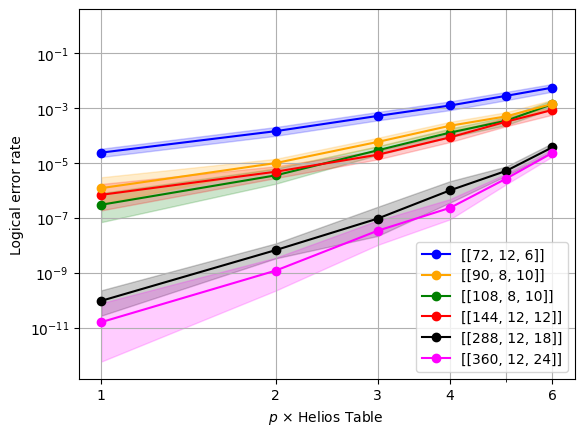

In [9]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: 1e3 * stats.json_metadata['p'], ## !!!!! HELIOS NOISE WE MULTIPLY BY 1e3 AS IT'S TIMES THE HELIOS NOISE TABLE
    
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
    filter_func=lambda s: 
        s.json_metadata['p'] >0,
        #and s.json_metadata['b'] == 'Z' ,
        # and '288' not in s.json_metadata['nkd'],
    plot_args_func = lambda index, curve_id: {
        'color': 'green' if '108' in curve_id else 'red' if '144' in curve_id else 'orange' if '90' in curve_id else 'blue' if '72' in curve_id else 'black' if '288' in curve_id else 'magenta',
        'marker': 'o'
})
my_axis_options(ax)

In [27]:
for stat in collected_stats:
    if '288' in stat.json_metadata['nkd']:
        print(stat)

print(sinter.shot_error_rate_to_piece_error_rate(shot_error_rate = 13/7578096672, pieces=24))
print(sinter.shot_error_rate_to_piece_error_rate(shot_error_rate = 3/7814504186, pieces=24))

7578096672,        13,         0,64779140.4,bposd,becaafe1053d405ff3a6056be8d3cbc5555009998f303a8b238d871ba22b9e0d,"{""A"":""'300207'"",""B"":""'031020'"",""b"":""X"",""excl_opp_b_detectors"":""True"",""l"":12,""m"":12,""nkd"":""[[288_12_18]]"",""noise"":""helios"",""p"":0.001,""r"":18,""seq_gates"":""True""}",
 299650712,        36,         0,30645043.9,bposd,e62662dd2ae92d639ba4963b654bb99189ff36bd18b519e54112583c4519d76c,"{""A"":""'300207'"",""B"":""'031020'"",""b"":""X"",""excl_opp_b_detectors"":""True"",""l"":12,""m"":12,""nkd"":""[[288_12_18]]"",""noise"":""helios"",""p"":0.002,""r"":18,""seq_gates"":""True""}",
   1000000,        92,         0,1973352.7,bposd,80bd22df6cf91f6333a461834a022f4769957a111d8693a16d09bf3f58cd8aea,"{""A"":""'300207'"",""B"":""'031020'"",""b"":""X"",""excl_opp_b_detectors"":""True"",""l"":12,""m"":12,""nkd"":""[[288_12_18]]"",""noise"":""helios"",""p"":0.005,""r"":18,""seq_gates"":""True""}",
   1000000,        18,         0,1304688.4,bposd,11594d441c4e8

In [ ]:
# Memory times:
import numpy as np

def RMSE_MLE(n, k): # using the analytical solution for RMSE(p_MLE) for X~Bin(n,p) with n samples k hits
    MSE = (6*k**2 - n * k * (k + 6) + n**2 * (k + 2)) / (n**2 * (n + 2) * (n + 3))
    RMSE = np.sqrt(MSE)    
    return RMSE


p = 1e-3 

for stat in collected_stats:

    nkd = stat.json_metadata['nkd']

    if stat.json_metadata['p'] != 0.001:
        continue

    if nkd == '[[360_12_24]]':
        time_per_round = 0.592
    elif nkd == '[[288_12_18]]':
        time_per_round = 0.452
    else:
        continue

    num_rounds_as_number = stat.json_metadata['r']
    
    n = stat.shots
    k = stat.errors
    per_shot = k / n
    RMSE = RMSE_MLE(n, k)

    n = num_rounds_as_number
    pL_per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces = n)
    RMSE = (RMSE / n) * (1 - 2 * pL_per_round)**((1 / n) - 1) # propagating error (derivation in OneNote)
    
    nr = p / pL_per_round
    nr_uncertainty = nr * (RMSE / pL_per_round)

    
    memorytime = time_per_round * nr
    memorytime_uncertainty = memorytime * (nr_uncertainty / nr)

    print(f'{nkd}: {round(memorytime/60/60/24)} days')

[[288_12_18]]: 55 days
[[360_12_24]]: 428 days


In [19]:
sum = 0
for stat in collected_stats:
    sum = stat.seconds + sum

print(sum)



505253974.2490856
